<h1 style="font-family:times new roman;"> <center>Car Dataset Exploratory Analysis and Price Prediction</center> </h1>

<p><center style="color:#159364; font-family:times new roman; font-size:16px">Exploratory Analysis of Car Dataset. Price prediction model using linear regression.</center></p>

***

<h2 style='font-family:times new roman'>Introduction</h2>

<p style='font-size:16px;font-family:times new roman'>When purchasing a car, there are many factors that go into making that decision. It’s important that the car fits into the customer’s budget as well as their lifestyle. While purchasing a pre-owned vehicle is often a more economical option, the buyer may also consider the car’s mileage, condition, manufacturer, etc. Using a dataset containing information about vehicles listed on Craigslist in New York and New Jersey, we can identify interesting trends in the listings. We can also use linear regression to create a model that predicts the price of a car based on its model year.</p>

<h2 style='font-family:times new roman'>Data</h2>

<p style='font-size:16px;font-family:times new roman'>The dataset used in this analysis is publicly available from Kaggle [1]. The data includes relevant information from Craigslist car listings and is scraped by Kaggle user Austin Reese.</p>

<h2 style='font-family:times new roman'>Set Up Enviroment</h2>

<p style='font-size:16px;font-family:times new roman'>Import Packages.</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api  import ols

<p style='font-size:16px;font-family:times new roman'>Import dataset.</p> <p style='font-size:16px;font-family:times new roman'>NOTE: The dataset imported is a subset of <a href='https://www.kaggle.com/austinreese/craigslist-carstrucks-data'>craiglist used car dataset.</a> It excludes any car listings outside of New York and New Jersey.</p>

In [ ]:
cars_ny = pd.read_csv('../input/used-cars-ny-nj/cars_ny_nj.csv')

<h2 style='font-family:times new roman'>Clean Data</h2>

<p style='font-size:16px;font-family:times new roman'>Preview dataset.</p>

In [ ]:
cars_ny.info()
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

<p style='font-size:16px;font-family:times new roman'>Drop listings of cars that are sold for parts.</p>

In [ ]:
cars_ny['condition'].unique()
salvage_cars = cars_ny[cars_ny['condition']=='salvage']
cars_ny.drop(salvage_cars.index, inplace=True)

<p style='font-size:16px;font-family:times new roman'>Remove any non-car listings.</p>

In [ ]:
cars_ny['type'].unique()
not_cars = cars_ny[cars_ny['type'].isin(['other','van','bus'])]
cars_ny.drop(not_cars.index, inplace=True)

<p style='font-size:16px;font-family:times new roman'>Drop columns that will not be needed.</p>

In [ ]:
drop_col = ['Unnamed: 0','url', 'region_url','VIN', 'paint_color',
            'image_url','county','lat','long','posting_date']
cars_ny = cars_ny.drop(columns=drop_col)

<p style='font-size:16px;font-family:times new roman'>Check percentage of nulls for each column.</p>

In [ ]:
cars_ny.isnull().mean()

<p style='font-size:16px;font-family:times new roman'>Drop any column with more than 30% nulls.</p>

In [ ]:
null_cols = cars_ny.columns[cars_ny.isnull().mean() > 0.3]
cars_ny = cars_ny.drop(columns = null_cols)

<p style='font-size:16px;font-family:times new roman'>Drop rows with null values.</p>

In [ ]:
cars_ny =cars_ny.dropna()

<p style='font-size:16px;font-family:times new roman'>Check data types.</p>

In [ ]:
cars_ny = cars_ny.astype({'year':'int'})

<p style='font-size:16px;font-family:times new roman'>Check for duplicates.</p>

In [ ]:
cars_ny['id'].nunique() == len(cars_ny)

<h2 style='font-family:times new roman'>Analysis</h2>

**<p style='font-size:16px;font-family:times new roman'>1. How are the car prices distributed in the dataset?</p>**

In [ ]:
cars_ny['price'].nunique()

<p style='font-size:16px;font-family:times new roman'>Removing any cars with a $0 price.</p>

In [ ]:
zero_price = cars_ny[cars_ny['price'] == 0]
len(zero_price)
cars_ny.drop(zero_price.index, inplace=True)

<p style='font-size:16px;font-family:times new roman'>Removing rows with unrealistic low prices. Most likely they are just listings offering financing.</p>

In [ ]:
under_1k = cars_ny[cars_ny['price'] < 1000]
cars_ny.drop(under_1k.index, inplace=True)

<p style='font-size:16px;font-family:times new roman'>Removing cars with listing prices over $30,000.</p>

In [ ]:
cars_ny[['description','price']].sort_values(
    by='price',ascending=False).head(100)
over_30k = cars_ny[cars_ny['price'] > 30000]
len(over_30k)
cars_ny.drop(over_30k.index,inplace=True)


<p style='font-size:16px;font-family:times new roman'>The dataset shows that cars listed at a price of $3,000 to $7,000 are the most frequently occurring in the dataset. </p>

In [ ]:
plt.hist(cars_ny['price'], bins =15,color='PowderBlue',edgecolor='Gray')
plt.title('Price Distribution for Car Listings',
          fontsize=24, color='MediumSeaGreen')
plt.xlabel('Price', fontsize=16, color='MediumSeaGreen')
plt.annotate(text=
          '''Car prices ranging from
          3000 USD to 7000 USD are 
          the most commonly occuring.''', xy=(12000,1400),fontsize=10,
             backgroundcolor='Plum')
plt.show()

**<p style='font-size:16px;font-family:times new roman'>2. Which manufacturers are the most common in the dataset?</p>**

In [ ]:
len(cars_ny['manufacturer'].unique())

manu = cars_ny.groupby('manufacturer', as_index=False)['id'].count()
manu.rename(columns = {'id':'count'}, inplace=True)
manu = manu.sort_values(by='count', ascending=False).head(10)

<p style='font-size:16px;font-family:times new roman'>Unsurprisingly, Ford, Toyota and Honda are amongst the most common car manufacturers present in the dataset. </p>

In [ ]:
# # Color palette.
my_color_pal = [
    'MediumSeaGreen',
    'LightSeaGreen',
    'MediumAquaMarine',
    'LightSkyBlue',
    'LightSteelblue',
    'PowderBlue',
    'Plum',
    'LightSalmon',
    'LightPink',
    'Moccasin',
]

In [ ]:
width = manu['count']
y = manu['manufacturer'].apply(lambda x: x.upper())
plt.barh(y=y, width=width, color=my_color_pal, edgecolor='Gray')
plt.title('Top Ten Most Common Manufactureres', fontsize=24,
          color='MediumSeaGreen')
plt.show()

**<p style='font-size:16px;font-family:times new roman'>3. Does a correlation exist between model year and car price?</p>**

<p style='font-size:16px;font-family:times new roman'>The correlation matrix reveals that the strongest correlation exists between price and model year.</p>

In [ ]:
car_corr = cars_ny[['price','year','odometer']]
corr_matrix = car_corr.corr()
sns.heatmap(corr_matrix, annot=True,cmap=[
    'Moccasin',
    'PowderBlue',
    'LightSalmon',
    ])

plt.show()


<p style='font-size:16px;font-family:times new roman'>Let’s consider cars with model years older than 2000. By doing this we work under the assumption that most people purchasing car in 2021 would not buy a car that is more than 20 years old. Excluding older car models results in the correlation coefficient increasing from 0.43 in the previous matrix, to 0.69. The relationship between model year and price is stronger when we only consider cars made in the last 20 years. </p>

In [ ]:
car_corr = car_corr[car_corr['year'] >= 2000]
corr_matrix = car_corr.corr()
sns.heatmap(corr_matrix, annot=True,cmap=[
    'Moccasin',
    'PowderBlue',
    'LightSalmon',
    ])

plt.show()

<p style='font-size:16px;font-family:times new roman'>For cars made in the last twenty years, the price of the car, on average, will increase relative to its model year. People often choose older car models in an effort to save money. Although the argument can be made that an older model may require more maintenance and therefore the cost of repairs may be less cost effective over time.</p>

In [ ]:
df_year = cars_ny[cars_ny['year'] >= 2000].groupby(
    'year',as_index=False)['price'].mean()
x = df_year['year']
y = df_year['price']
plt.plot(x,y)
plt.title('Model Year vs Average Price', fontsize=24,
          color='MediumSeaGreen')
plt.show()

**<p style='font-size:16px;font-family:times new roman'>4. Price model prediction.</p>**

<p style='font-size:16px;font-family:times new roman'>Using the OLS method to create a simple, linear regression model.</p>

In [ ]:
model = ols('price~year', data=df_year).fit()
model.params

<p style='font-size:16px;font-family:times new roman'>The R-squared value for the model.</p>

In [ ]:
mse = model.mse_resid
rse = mse ** (1/2)

print('R-squared: {r} \nRSE: {rs}'.format(r=model.rsquared, rs=rse))

In [ ]:
years = pd.DataFrame({'year':df_year['year']})
predict_data = years.assign(price=model.predict(years))

<p style='font-size:16px;font-family:timesnewroman'>The predicted model graphed along with the observed data. The R-squared value, 0.9121, may indicate that model has a good fit for the data. The RSE value, how much the predictions are typically wrong, is 2080. The difference between predicted prices and the observed prices is $2,080.This can easily be considered a big difference if your car budget is closer to $5,000 than $30,000.</p>

In [ ]:
fig = plt.figure()
sns.regplot(
    x='year',
    y='price',
    ci=None,
    data=df_year,
    )
sns.scatterplot(
    x='year',
    y='price',
    data=predict_data,
    color='red',
    marker='s',
    label = 'Model R-squared:0.9121192123740777')
plt.title('Prediction Model & Observed Data')
plt.show()

<h2 style='font-family:times new roman'>Conclusison</h2>

<p style='font-size:16px;font-family:times new roman'>The exploratory analysis of this dataset revealed interesting trends about cars listed in the New York-New Jersey area. If you are looking to purchase a car through Craigslist, cars between $3,000  and  $7,000 are the most frequently listed. It may also be easier to find cars made by either Ford, Chevrolet or Toyota, as they are the most frequently recurring manufacturers in the dataset. Lastly, if purchasing a car on a limited budget, it should be noted that the price difference, on average, between a car with a 2000 model year and one with 2020 is $16,900.</p>

<h2 style='font-family:times new roman'>Tableau Dashboard</h2>

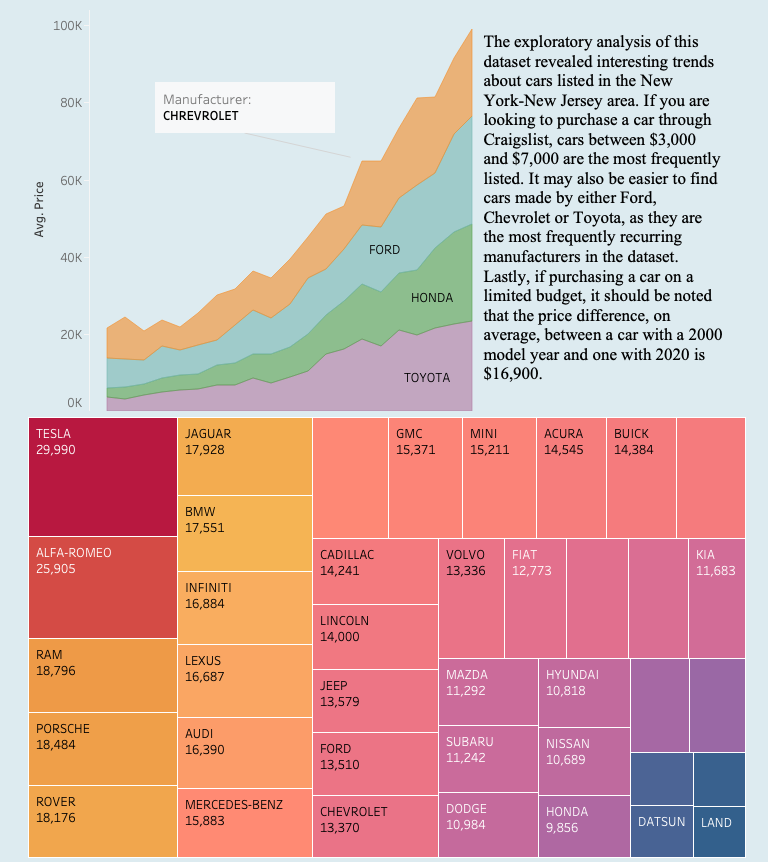

<h2 style='font-family:times new roman'>References</h2>

1.	[Austin Reese’s Craiglist Cars Dataset on Kaggle.](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)
2.	[Tarique Akhtar’s Article on predicting car prices using machine learning.](https://towardsdatascience.com/predicting-car-price-using-machine-learning-8d2df3898f16)
3.	[Brandon Fotz’s Youtube video on linear regression (pt.1)]( https://www.youtube.com/watch?v=kHZBy1uVNnM)
4.   [Brandon Fotz’s Youtube video on linear regression (pt.2)]( https://www.youtube.com/watch?v=Qa2APhWjQPc)
5.   [Brandon Fotz’s Youtube video on linear regression (pt.3)](https://www.youtube.com/watch?v=ZkjP5RJLQF4)




